# Introduction

This is a recreation of a case study done by Victoria Catterson on [cowlet.org](http://cowlet.org/2013/09/15/understanding-data-science-feature-extraction-with-r.html) using the programming language R. It caught my attention since it involves a form of machine learning that can be used for predictive maintenance which I have been interested in lately. She already provides the code in R so to force myself to learn more from it I decided to recreate the case study using Python. This introduction is largely given by her on the link provided above with some minor changes.

The data used is from the [Prognostic Data Repository](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/) hosted by NASA, and specifically [the bearing dataset from University of Cincinnati](http://ti.arc.nasa.gov/c/3/). The data was gathered from an experiment studying four bearings installed on a loaded rotating shaft, with a constant speed of 2,000rpm. With the following test setup ([Qiu et al](http://www.sciencedirect.com/science/article/pii/S0022460X0500221X)):
<br />

![](https://databoers.com/wp-content/uploads/2018/02/bearings_qiu-et-al.jpg)

In the course of this experiment, some of the bearings broke down. Victoria Catterson decided to look at the data in detail, to see if she could identify early indicators of failure.

# What are bearings?
A basic understanding of the data you are trying to analyse is always necesary to prevent you from making elementary mistakes. This case is no different. As is usually the case with data science a broad knowledge of all fields comes in handy. However let's continue with what bearings are, in the words of Victoria:

"<i>Bearings are key components of all types of rotating machinery, from simple desk fans to nuclear power station turbines. Anything with a motor or generator rotates a shaft, and the health of the bearings determines how smoothly and efficiently that shaft rotates. Poor lubrication of the bearing will generate extra friction, which reduces efficiency and can also damage the bearing or shaft. In the worst cases, the bearing can scuff or crack, and metal particles break free to hit and damage other parts of the machine</i>"

There are also different types of bearings which influence their service life, for example there are 'fluid and magnetic bearings' that have been in continuous service since 1900 and have no signs of wear. Those would be no fun to investigate however! The bearings in this case are 'Rolling element bearings', whose service life is largely determined by load, temperature, maintenance, lubrication and other factors. Fault detection is mainly done through the measurement of vibration, the natural frequencies of a rolling element bearing is around 3 kHz. To measure this vibration a range-accelorometer is placed on the equipment. For the [Qiu, et al](http://www.sciencedirect.com/science/article/pii/S0022460X0500221X). experiment there were two such accelerometers per bearings measuring the x and y axes.

# Data Composition
Now we are somewhat familiar with what a bearing is and how they measured them. It is important to do a cursory inspection of your data before loading it so you know what to expect and efficiently go through it. The downloaded [dataset](http://ti.arc.nasa.gov/c/3/) contains a PDF detailing the experiment and data format. Extracting all of the files gives you three directories containing files. The 1st_test directory contains 2,156 files. These files are named according to timestamp and contain an 8 x 20,480 matrix of tab-seperated vaules. These columns correspond to the 2 accelerometers and the rows are the 20kHz samples from 1 second of operation. Now at this point Victoria mentions a key point that I would have missed until it would have showed up in plotting:

<i>"If the sampling rate is 20kHz and each file contains 1 second of data, there should be 20,000 rows of data. Since there are 20,480, one of these pieces of information about the data is wrong. Is it the sampling rate or the time period?"</i>

If the sampling rate is different from 20kHz to say 20.48kHz that would be a significant error for high frequency data. However if the time period of the samping is 1.024s it would explain it being rounded down to 1 second. Checking data consistency is important, this prevents misunderstandings and invalid results in the future.

# Importing the data
Now that we took a proper look at what the data is that we have we want to load it. I choose to use the 'pandas' package in Python which allows me to create dataframes similar to the way you create a matrix in R. Another package which always comes in handy is 'matplotlib' for basic plotting functionality. Lets start with a single file and prepare it accordingly before loading the other 2,155 files.




In [45]:
# Importing pandas and other packages
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
%matplotlib inline

basedir = 'D:/Databoers/data/bearings/1st_test/'
test_file = '2003.10.22.12.06.24'

# The basedir contains tab seperated files
data = pd.read_csv(basedir+test_file, sep='\t', header=None)
data.head()

,0,1,2,3,4,5,6,7
0,-0.022,-0.039,-0.183,-0.054,-0.105,-0.134,-0.129,-0.142
1,-0.105,-0.017,-0.164,-0.183,-0.049,0.029,-0.115,-0.122
2,-0.183,-0.098,-0.195,-0.125,-0.005,-0.007,-0.171,-0.071
3,-0.178,-0.161,-0.159,-0.178,-0.100,-0.115,-0.112,-0.078
4,-0.208,-0.129,-0.261,-0.098,-0.151,-0.205,-0.063,-0.066


The data was loaded succesfully, now we can change the header information to me more informative.

In [2]:
data.columns = ['b1_x', 'b1_y', 'b2_x', 'b2_y', 'b3_x', 'b3_y', 'b4_x', 'b4_y']
data.head()

,b1_x,b1_y,b2_x,b2_y,b3_x,b3_y,b4_x,b4_y
0,-0.022,-0.039,-0.183,-0.054,-0.105,-0.134,-0.129,-0.142
1,-0.105,-0.017,-0.164,-0.183,-0.049,0.029,-0.115,-0.122
2,-0.183,-0.098,-0.195,-0.125,-0.005,-0.007,-0.171,-0.071
3,-0.178,-0.161,-0.159,-0.178,-0.100,-0.115,-0.112,-0.078
4,-0.208,-0.129,-0.261,-0.098,-0.151,-0.205,-0.063,-0.066


# Initial analysis
Now that we have a first look at the data we can start analysing to see what we can find out. Are there any obvious outliers? What aspects need cleaning? Do we store it in seperate files or one big dataframe? 

To start we are just going to get a summary of the data and make a plot out of this. Then we see if we can make any meaningful observations.

In [3]:
data['b1_x'].describe()

count    20480.000000
mean        -0.094593
std          0.081124
min         -0.720000
25%         -0.146000
50%         -0.095000
75%         -0.042000
max          0.388000
Name: b1_x, dtype: float64

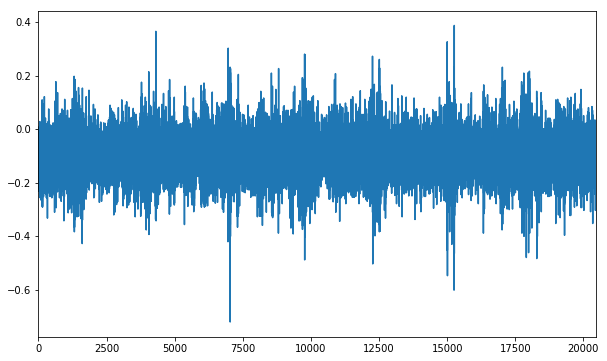

In [4]:
data['b1_x'].plot.line()

# Observations
So looking at the above plot and summary of the x axis for the 1st bearing we can make some  observations. A visual inspection of the plot shows that the largest amount of variation is centered below 0, the mean being -.09 supports that. The vibrations are mainly centered between 0 and 0.2, there are some noticable outliers. The max and min values are 0.388 and -0.720 which are not orders of magnitude different from the rest of the measurements, which suggests they are true measurements. The other columns show similar patterns.

However each of these plots only shows a snapshot of a second for each of the bearings. To do a full analysis we need to take into account all of the measurements. And we are not going to go through thousands of plots by hand. So instead of that we need to find another way to analyze the data.

# Feature Extraction
So we currently have 2,156 files with 20,480 datapoints. So roughly 44 million datapoints, it is feasible to do computation with this using appropriate algorithms and cpu time. However we are going to extract some features to reduce the dimensionality of the data. A risk here is that by removing features we lose valuable information about the actual data.

### Fast Fourier Transform (FFT)
A popular technique for studying mechanical components such as bearings is [Vibration Analysis]([https://en.wikipedia.org/wiki/Vibration) (VA). It can be effectively used to detect faults in rotating equipment to find rolling element bearing faults. VA uses units of Displacement, Velocity and Acceleration displayed as [Time Waveforms](https://en.wikipedia.org/wiki/Waveform). To use these we can transform them into a spectrum using a [Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) of these Time Waveforms. The Python package '[numpy](http://www.numpy.org/)' can be used for scientific computing, including the numpy.fft() function to perform a Fast Fourier Transform. Additionally we perform some steps to make the format more managable to plot. To plot the following I decided to use the 'plotly' package which is very nice to generate interactive plots.


In [9]:
# First we take the absolutes of the fast fourier transform
amplitude = np.absolute(np.fft.fft(data['b1_x']))

# Now we ignore the 2nd half of the transform as being complex conjugates of the 1st half
amplitude = amplitude[0:(int(len(amplitude)/2))]

#Calculate frequencies
frequency = numpy.linspace(0,10000, len(amplitude))

trace = go.Scatter(x = frequency, y = amplitude)
data = [trace]
layout = go.Layout(title="Frequency vs Amplitude after FFT",
                  xaxis=dict(title='Frequency'),
                  yaxis=dict(title='Amplitude'))
fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

The most noticable spikes seem to be on the lower frequencies. There is some activity around 4kHz and 8kHz as well. But lets zoom in on the lower frequencies first.


In [14]:
layout = go.Layout(title="Frequency vs Amplitude after FFT",
                  xaxis=dict(title='Frequency', range=[0,1100]),
                  yaxis=dict(title='Amplitude', range=[0,500]))
fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

Other than the dc term (at 0Hz), the tallest spikes are just below 1kHz. There is also a large spike just below 500Hz, and two around 50Hz. The interactive plot enables us to check what frequencies the outliers are on. However we might want to put all of this in a table for easier viewing:


In [44]:
top_outliers = sorted(zip(amplitude, frequency), reverse=True)[:10]
df = pd.DataFrame.from_records(top_outliers)
df.columns = ['Amplitude', 'Frequency']

df = df.transpose()
df.columns = [i+1 for i in range(10)]
df

,1,2,3,4,5,6,7,8,9,10
Amplitude,1937.262,568.025449,181.099925,125.348528,102.899711,95.688706,78.623396,65.746995,63.723709,63.313016
Frequency,0.000,986.424456,993.261061,493.212228,979.587850,994.237719,969.821272,971.774587,57.622815,978.611192


The previously mentioned outliers appear to be on 49.8Hz, 57.6Hz, and 493Hz. Interestingly, the second and fourth largest components have a harmonic relationship (493Hz * 2 = 986Hz), which strongly suggests they are linked. It would be worth looking the frequencies of the largest five components as displayed here (exluding the 0Hz dc term measurement). Since each bearing has an x and y axis, this means there will be 10 features total. However this concludes our introduction, we will continue this investigation in the next post.


# Next Steps

- Feature Selection
- Processing all files
- Standardizing functions

These steps will require us to convert all the files into 4 files, one for each bearing. This means we will have 4 files each having 2,156 rows (one for each file) with the timestamp being the first column and the key features extracted following this calculated from the measurements at that time.

Until next time!